In [1]:
import pandas as pd 
import numpy as np

In [3]:
temp= pd.read_csv("temperature.csv")
prec=pd.read_csv("precipitation.csv")

In [5]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69880 entries, 0 to 69879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69880 non-null  object 
 1   lat     69880 non-null  float64
 2   long    69880 non-null  float64
 3   elev    69880 non-null  int64  
 4   tmin    56824 non-null  float64
 5   tmax    56824 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.2+ MB


In [7]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567775 entries, 0 to 567774
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    567775 non-null  object 
 1   lat     567775 non-null  float64
 2   long    567775 non-null  float64
 3   elev    567775 non-null  int64  
 4   precip  567775 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.7+ MB


## Veri Setlerinde Tutarsızlık var Uygun bir Aralığa sokmaya Çalışacağım

In [10]:
temp = temp.sort_values(["lat","long","date"])
prec = prec.sort_values(["lat","long","date"])

In [12]:
temp.loc[(temp.tmin < -60) | (temp.tmin > 60), "tmin"] = np.nan
temp.loc[(temp.tmax < -60) | (temp.tmax > 60), "tmax"] = np.nan

In [14]:
temp[["tmin","tmax"]] = (
    temp.groupby(["lat","long"])[["tmin","tmax"]]
        .apply(lambda g: g.interpolate(limit=3).bfill(limit=1).ffill(limit=1))
        .reset_index(level=[0,1], drop=True)
) #Boşlukları varsa dolduruyorum

In [16]:
for df in (temp, prec):  #Fark oluşturmayacak değerleri yuvarlıyorum ki daha net bir veri elde edeyim
    df["lat"] = df["lat"].round(2)
    df["long"] = df["long"].round(2)

In [18]:
print( temp[["lat","long"]].drop_duplicates().shape[0])   ##Unique değerleri bulmak için
print( prec[["lat","long"]].drop_duplicates().shape[0])

8
65


In [20]:
coords_temp = temp[["lat","long"]].drop_duplicates()  #Ortak koordinatları bulmak için
coords_prec = prec[["lat","long"]].drop_duplicates()
inner_coords = coords_temp.merge(coords_prec, on=["lat","long"])
print(inner_coords.shape[0])

1


In [22]:
#Ortak koordinatımız yok maalesef bo zaman nearest-neighbor ile eşleştiricez

In [24]:
from sklearn.neighbors import NearestNeighbors

In [25]:
temp_coords = np.radians(temp[["lat","long"]].drop_duplicates().values)  
prec_coords = np.radians(prec[["lat","long"]].drop_duplicates().values)

In [28]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree", metric="haversine").fit(temp_coords)
dist, idx = nbrs.kneighbors(prec_coords)  #İnternetten uygun metriği ve algorithmi buldum şimdi birleştiricez

In [30]:
earth_radius_km = 6371.0088  #Mesafeyi kilometreye çeviriyorum çünkü küçük bir alanda tahmin modeli geliştireceğim parametreyi ona göre seçmem gerek
dist_km = dist[:,0] * earth_radius_km 

In [32]:
mask = dist_km <= 30  # 30 km eşik
prec_unique = prec[["lat","long"]].drop_duplicates().reset_index(drop=True)
temp_unique = temp[["lat","long"]].drop_duplicates().reset_index(drop=True)

In [34]:
map_df = prec_unique.loc[mask].copy()
map_df["lat_temp"]  = temp_unique.loc[idx[mask,0], "lat"].values
map_df["long_temp"] = temp_unique.loc[idx[mask,0], "long"].values #birleştirme adımları

In [36]:
prec_m = prec.merge(map_df, on=["lat","long"], how="inner")
temp_m = temp.rename(columns={"lat":"lat_temp","long":"long_temp"})

In [38]:
df = prec_m.merge(temp_m, on=["date","lat_temp","long_temp"], how="inner", suffixes=("_prec","_temp"))
df = df.rename(columns={"lat_temp":"lat","long_temp":"long"})
df["tavg"] = (df["tmin"] + df["tmax"]) / 2

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559040 entries, 0 to 559039
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       559040 non-null  object 
 1   lat        559040 non-null  float64
 2   long       559040 non-null  float64
 3   elev_prec  559040 non-null  int64  
 4   precip     559040 non-null  float64
 5   lat        559040 non-null  float64
 6   long       559040 non-null  float64
 7   elev_temp  559040 non-null  int64  
 8   tmin       515610 non-null  float64
 9   tmax       515610 non-null  float64
 10  tavg       515610 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 46.9+ MB


In [42]:
print(df.isna().sum()) #Veriyi ilk elime aldığımda birleştirince 4milyon değer döndürürken bunların 3.9 milyonu boştu

date             0
lat              0
long             0
elev_prec        0
precip           0
lat              0
long             0
elev_temp        0
tmin         43430
tmax         43430
tavg         43430
dtype: int64


In [43]:
#Şimdiki verimizde yol katettik diyebiliriz veriler doğru birleşti ve boş veri sayımız 10da 1ine düştü

In [44]:
df.head()

,date,lat,long,elev_prec,precip,lat,long,elev_temp,tmin,tmax,tavg
0,2001-01-01,40.75,29.85,2,5.382090,40.75,29.75,0,8.9,15.4,12.15
1,2001-01-02,40.75,29.85,2,0.000000,40.75,29.75,0,9.3,10.1,9.70
2,2001-01-03,40.75,29.85,2,0.000000,40.75,29.75,0,5.9,12.6,9.25
3,2001-01-04,40.75,29.85,2,0.053445,40.75,29.75,0,-0.3,11.9,5.80
4,2001-01-05,40.75,29.85,2,0.000000,40.75,29.75,0,6.5,12.2,9.35


In [45]:
#Kalan boşulkarı düzeltmek için birkaç işlem daha yapacağım.

In [46]:
for a, b, out in [
    ("lat_temp", "lat_prec", "lat"),
    ("long_temp", "long_prec", "long")
]:
    if a in df.columns or b in df.columns:
        df[out] = df.get(a, pd.Series(index=df.index, dtype="float64")).fillna(
                    df.get(b, pd.Series(index=df.index, dtype="float64"))
                  )

In [52]:
df = df.loc[:, ~df.columns.duplicated()]

In [54]:
keep = ["date","lat","long","elev_temp","elev_prec","tmin","tmax","precip"]
df = df[[c for c in keep if c in df.columns]].copy()

In [56]:
df["date"] = pd.to_datetime(df["date"])
df["lat"]  = df["lat"].astype(float).round(4)
df["long"] = df["long"].astype(float).round(4)

In [58]:
df.head()

,date,lat,long,elev_temp,elev_prec,tmin,tmax,precip
0,2001-01-01,40.75,29.85,0,2,8.9,15.4,5.382090
1,2001-01-02,40.75,29.85,0,2,9.3,10.1,0.000000
2,2001-01-03,40.75,29.85,0,2,5.9,12.6,0.000000
3,2001-01-04,40.75,29.85,0,2,-0.3,11.9,0.053445
4,2001-01-05,40.75,29.85,0,2,6.5,12.2,0.000000


In [60]:
#Datayı doldurmaya çalışırken hata vermişti çünkü 1 sütundan 1den fazla vardı ve farklı değerlerdeydi 

In [62]:
#Ben de çoğul sütünları ortalamalarına göre birleştirip tek sütun oluşturdum

In [64]:
for i in ["tmin","tmax"]:  #interpolate ile kısa boşlukları dolduruyoruz
    df[i] = (df
               .groupby(["lat","long"], group_keys=False)[i]
               .apply(lambda s: s.interpolate(limit=3)))

In [66]:
df["month"] = df["date"].dt.month #aylardaki sıcaklık değerleri ortalamalarına göre kalan boşlukları dolduruyoruz
for col in ["tmin","tmax"]:
    clim = df.groupby(["lat","long","month"])[col].transform("mean")
    df[col] = df[col].fillna(clim)

In [68]:
df["tavg"] = (df["tmin"] + df["tmax"]) / 2

In [70]:
df[["tmin","tmax","tavg"]].isna().sum()

tmin    0
tmax    0
tavg    0
dtype: int64

In [72]:
#Tüm boşlukları doldurduk

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559040 entries, 0 to 559039
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       559040 non-null  datetime64[ns]
 1   lat        559040 non-null  float64       
 2   long       559040 non-null  float64       
 3   elev_temp  559040 non-null  int64         
 4   elev_prec  559040 non-null  int64         
 5   tmin       559040 non-null  float64       
 6   tmax       559040 non-null  float64       
 7   precip     559040 non-null  float64       
 8   month      559040 non-null  int32         
 9   tavg       559040 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(1), int64(2)
memory usage: 40.5 MB


In [76]:
df.head()

,date,lat,long,elev_temp,elev_prec,tmin,tmax,precip,month,tavg
0,2001-01-01,40.75,29.85,0,2,8.9,15.4,5.382090,1,12.15
1,2001-01-02,40.75,29.85,0,2,9.3,10.1,0.000000,1,9.70
2,2001-01-03,40.75,29.85,0,2,5.9,12.6,0.000000,1,9.25
3,2001-01-04,40.75,29.85,0,2,-0.3,11.9,0.053445,1,5.80
4,2001-01-05,40.75,29.85,0,2,6.5,12.2,0.000000,1,9.35


In [78]:
(df["tmin"] > df["tmax"]).any()

False

In [80]:
(df["precip"] < 0).any()

False

In [82]:
#Son kez mantıksız verileri de kontrol ettik artık analizine geçebiliriz.

## Analize 

In [85]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,559040,2012-12-16 00:00:00.000000256,2001-01-01 00:00:00,2006-12-24 00:00:00,2012-12-16 00:00:00,2018-12-09 00:00:00,2024-11-30 00:00:00,NaN
lat,559040.0,41.09375,40.75,40.95,41.05,41.15,41.45,0.163817
long,559040.0,29.05625,28.15,28.45,29.2,29.65,29.95,0.632178
elev_temp,559040.0,43.234375,0.0,0.0,0.0,108.0,108.0,48.163418
elev_prec,559040.0,73.890625,0.0,33.5,63.0,110.0,216.0,52.650165
tmin,559040.0,11.355047,-10.1,5.899732,11.3,17.327222,27.4,6.847769
tmax,559040.0,19.485441,-4.6,12.8,19.8,26.9,41.6,8.385616
precip,559040.0,2.358207,0.0,0.0,0.01606,1.017212,149.81065,6.733847
month,559040.0,6.503492,1.0,4.0,7.0,9.0,12.0,3.439323
tavg,559040.0,15.420244,-6.05,9.35,15.45,22.05,31.5,7.393829


In [87]:
import matplotlib.pyplot as plt

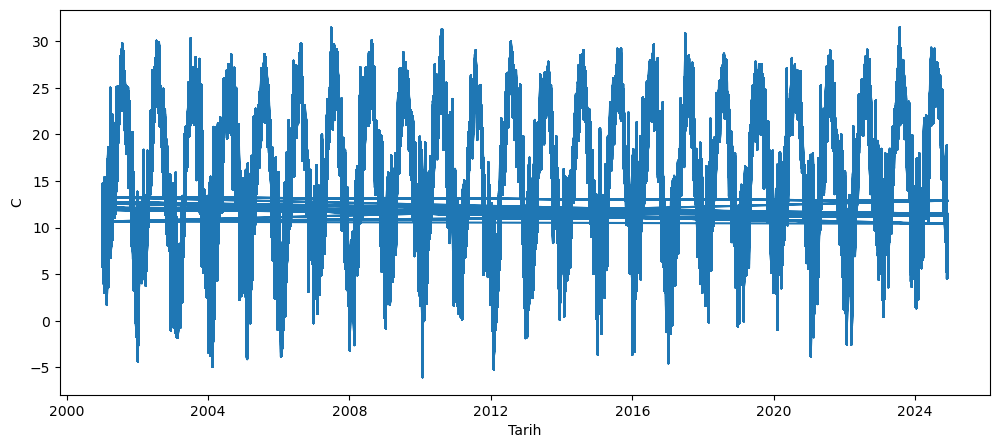

In [89]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["tavg"], label="Ortalama Sıcaklık (C)")
plt.ylabel("C")
plt.xlabel("Tarih")
plt.show()


In [90]:
# Sıcaklık içilen çizilen grafikten düzenli bir sıcaklık gösterdiğini anlayabiliyoruz.

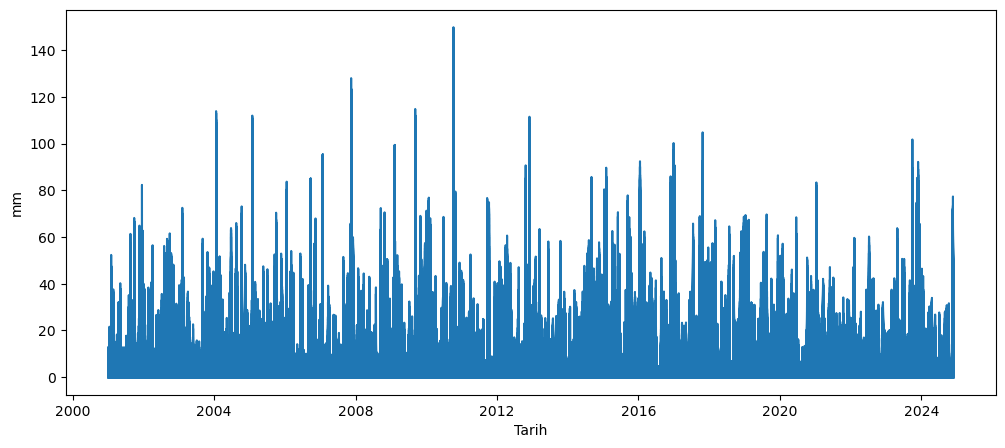

In [93]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["precip"], label="Yağış (mm)")
plt.ylabel("mm")
plt.xlabel("Tarih")
plt.show()

In [94]:
df["year"] = df["date"].dt.year

In [97]:
monthly = df.groupby(["year","month"]).agg(
    monthly_tavg=("tavg","mean"),
    monthly_precip=("precip","sum")
).reset_index()

In [99]:
df.head()

,date,lat,long,elev_temp,elev_prec,tmin,tmax,precip,month,tavg,year
0,2001-01-01,40.75,29.85,0,2,8.9,15.4,5.382090,1,12.15,2001
1,2001-01-02,40.75,29.85,0,2,9.3,10.1,0.000000,1,9.70,2001
2,2001-01-03,40.75,29.85,0,2,5.9,12.6,0.000000,1,9.25,2001
3,2001-01-04,40.75,29.85,0,2,-0.3,11.9,0.053445,1,5.80,2001
4,2001-01-05,40.75,29.85,0,2,6.5,12.2,0.000000,1,9.35,2001


In [101]:
#Korelasyon Analizi

In [103]:
import seaborn as sns

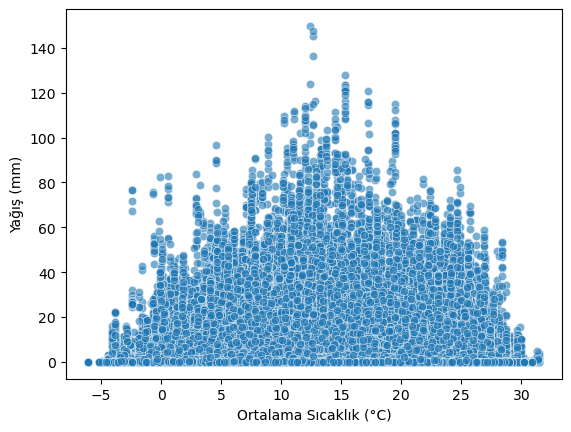

In [104]:
sns.scatterplot(x="tavg", y="precip", data=df, alpha=0.6)
plt.xlabel("Ortalama Sıcaklık (°C)")
plt.ylabel("Yağış (mm)")
plt.show()

In [106]:
df["tavg"].corr(df["precip"]) #Sıcaklığın yağışa göre korelasyonu

-0.0824845905175866

In [107]:
#10-20 derece sıcaklıklar arasında yağısın maksimum olduğu sonucuna varabiliriz buradan

In [108]:
seasonal = df.groupby(df["date"].dt.month).agg(
    mean_temp=("tavg", "mean"),
    mean_precip=("precip", "mean")
).reset_index()  #aylara göre bakacağız mevsimleri görebilmek için

Text(0, 0.5, 'Yağış (mm)')

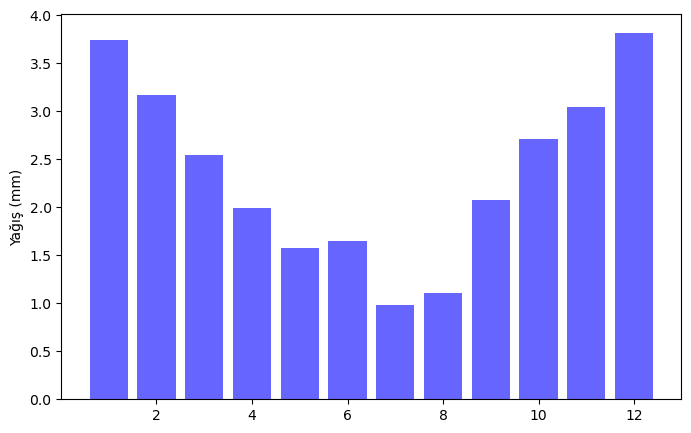

In [109]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(seasonal["date"], seasonal["mean_precip"], color="blue", alpha=0.6, label="Yağış (mm)")
ax1.set_ylabel("Yağış (mm)")

In [110]:
#Tahmin edebileceğimiz gibi verimiz istanbulda olduğu için böyle bir grafik çıkması muhtemeldi bu da doğru ilerlediğimizi gösterir.

In [111]:
#Son olarak net bir şey görmek için korelasyon grafiğini de çizelim.

In [112]:
pair_df = df[["tavg", "precip"]].copy()
pair_df["month"] = df["date"].dt.month

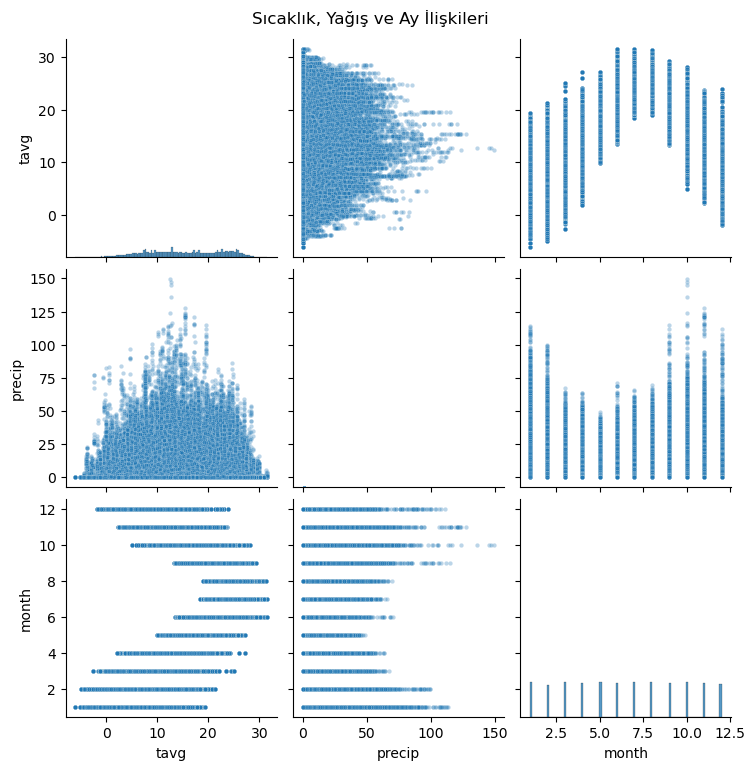

In [113]:
sns.pairplot(pair_df, diag_kind="hist", plot_kws={"alpha":0.3, "s":10})
plt.suptitle("Sıcaklık, Yağış ve Ay İlişkileri", y=1.02)
plt.show()

## Tahmin modeli

In [123]:
#Gerekli kütüphaneleri import edelim

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [130]:
!pip install lightgbm

In [125]:
#Veri setini hazırlayalım

In [126]:
df["month"] = df["date"].dt.month
X = df[["tavg", "month"]].copy()
y = df["precip"].copy()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
#%20 lik bir test size ayırıyoruz ve train-test datamızı bölüyoruz

In [128]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["month"]),
        ("num", "passthrough", ["tavg"]),])

In [129]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=None, n_jobs=-1, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LightGBM": LGBMRegressor(
        n_estimators=300, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1
    )}

#yapay zeka yardımıyla modellerin en hızlı değerlerini buldum.

In [138]:
results = []
fitted = {}

#değerleri bu liste ve fitted edilmiş modelleri bu dict e kaydedeceğiz

In [275]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("reg", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))
    fitted[name] = pipe

KeyboardInterrupt: 

In [131]:
#LightGBM'in bu hatası yağışı açıklayacak anlamlı bir bölünme bulamadığını söylüyor. O zaman yapay zekadan destek alarak şimdi setimizi genişleticez

In [140]:
df = df.sort_values(["lat","long","date"]).copy()

In [142]:
df["doy"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month


In [144]:
# Mevsimsellik (dairesel encoding)
df["sin_doy"] = np.sin(2*np.pi*df["doy"]/365.25)
df["cos_doy"] = np.cos(2*np.pi*df["doy"]/365.25)

In [146]:
grp = df.groupby(["lat","long"], group_keys=False)

In [148]:
# Yağış gecikmeleri
df["precip_lag1"] = grp["precip"].shift(1)
df["precip_lag3"] = grp["precip"].shift(3)
df["precip_lag7"] = grp["precip"].shift(7)

In [150]:
df["precip_sum3"]  = grp["precip"].rolling(3, min_periods=1).sum().reset_index(level=[0,1], drop=True)
df["precip_sum7"]  = grp["precip"].rolling(7, min_periods=1).sum().reset_index(level=[0,1], drop=True)
df["tavg_mean7"]   = grp["tavg"].rolling(7, min_periods=1).mean().reset_index(level=[0,1], drop=True)

In [151]:
feat_cols = [
    "tavg","tmin","tmax","month","sin_doy","cos_doy",
    "precip_lag1","precip_lag3","precip_lag7",
    "precip_sum3","precip_sum7","tavg_mean7",
    "lat","long"]

In [154]:
model_df = df.dropna(subset=["precip"] + feat_cols).copy()

In [156]:
X = model_df[feat_cols]
y = model_df["precip"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

#Yapay zekadan destek alarak parametreleri çoğalttık şimdi tekrar modelimizi oluşturuyoruz.

In [158]:
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), ["month"])],
    remainder="passthrough")

In [165]:
lgbm_params = Pipeline([
    ("pre", pre),
    ("reg", LGBMRegressor(
        objective="tweedie",          
        tweedie_variance_power=1.3,   
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=63,
        min_data_in_leaf=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))])

In [155]:
lgbm_params.fit(X_train, y_train)
pred = lgbm_params.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 446873, number of used features: 25
[LightGBM] [Info] Start training from score 0.859286
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


In [157]:
print("Tweedie LightGBM - RMSE:", rmse, " R²:", r2)

Tweedie LightGBM - RMSE: 2.2764465603549002  R²: 0.8858771831460552


In [159]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"]).sort_values("R2", ascending=False)
print(results_df)

Empty DataFrame
Columns: [Model, RMSE, R2]
Index: []


In [161]:
#Sonuçlar kötü geldiği için yeni parametreler eklenmiş veriyle tekrar train yapıcam.
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=None, n_jobs=-1, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1
    )}

In [163]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("prep", pre),
        ("reg", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))
    fitted[name] = pipe

In [165]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"]).sort_values("R2", ascending=False)
print(results_df)

              Model      RMSE        R2
1      RandomForest  2.177961  0.895538
3           XGBoost  3.057983  0.794066
2  GradientBoosting  4.084121  0.632671
0  LinearRegression  4.573480  0.539371


In [160]:
#şimdiki sonuçlarımıza göre en iyi sonuç veren model RondemForest o yüzden onunla devam edicez

In [162]:
#RandomForest modeline tuning yapalım

In [174]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [176]:
param_dist = {
    "reg__n_estimators": randint(200, 900),
    "reg__max_depth": randint(6, 32),
    "reg__min_samples_split": randint(2, 20),
    "reg__min_samples_leaf": randint(1, 10),
    "reg__max_features": uniform(0.4, 0.6), 
}

In [178]:
#veriyi küçültüyorum ki işlem daha hızlı gerçekleşsin
df["wet"] = (df["precip"] > 0).astype(int)
key = df["month"].astype(str) + "_" + df["wet"].astype(str)
sample_idx = df.groupby(key, group_keys=False).apply(lambda g: g.sample(frac=0.2, random_state=42)).index
df_sub = df.loc[sample_idx].copy()

In [179]:
df_sub["month"] = df_sub["date"].dt.month

In [182]:
X = df_sub[feat_cols].copy()      
y = df_sub["precip"].copy()

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [186]:
preprocessor = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), ["month"])],
    remainder="passthrough"
)

In [188]:
rf_pipe = pipe = Pipeline(steps=[
        ("prep", pre),
        ("reg", RandomForestRegressor(random_state=42,n_jobs=-1))
    ])

In [190]:
rnd_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=20, cv=3, scoring="r2", n_jobs=-1, random_state=42
)
rnd_search.fit(X_train, y_train)

C:\Users\musta\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['month'])])),
                                             ('reg',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'reg__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object...
                                        'reg__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B1B9F80830>,
                                        'reg__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1B9F82780>,
                                        'reg__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1B9F830E0>,
                                        'reg__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1B9F7FE60>},
                   random_state=42, scoring='r2')

In [193]:
rnd_search.best_params_

{'reg__max_depth': 26,
 'reg__max_features': 0.6702995511817258,
 'reg__min_samples_leaf': 2,
 'reg__min_samples_split': 5,
 'reg__n_estimators': 800}

In [195]:
#Çalışan en iyi parametreleri de bulduk.

In [197]:
rnd_search.best_score_

0.7295533149418237

In [199]:
#Skorumuz da fena değil %73 bir başarımız var neredeyse en sağlıklı parametrelerde

In [201]:
#Şimdi en iyi parametrelerle modelimizi fit edicez

In [203]:
best_params = rnd_search.best_params_


In [205]:
rf_kwargs = {k.replace("reg__",""): v for k,v in best_params.items()}

In [209]:
final_pipe = Pipeline([
    ("prep", pre),
    ("reg", RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True, **rf_kwargs))])

In [213]:
#En son train-test splitimi yapıyorum yine %20lik olacak şekilde modelleri hep öyle gerçekleştirdik çünkü

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42)

In [215]:
final_pipe.fit(X_tr, y_tr)

C:\Users\musta\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('reg',
                 RandomForestRegressor(max_depth=26,
                                       max_features=0.6702995511817258,
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=800, n_jobs=-1,
                                       random_state=42))])

In [217]:
y_hat = final_pipe.predict(X_te)

In [223]:
np.sqrt(mean_squared_error(y_te, y_hat))

3.158473791740248

In [227]:
r2_score(y_te, y_hat)

0.7877279580343839

In [229]:
#Skorlarımız güzel r2 skorumuza göre %78-79luk bir başarı oranımız var en iyi parametrelerle.

In [231]:
#Şimdi modelimizin predictleriyle gerçek arasındaki farkları bir de grafiklerde görelim.

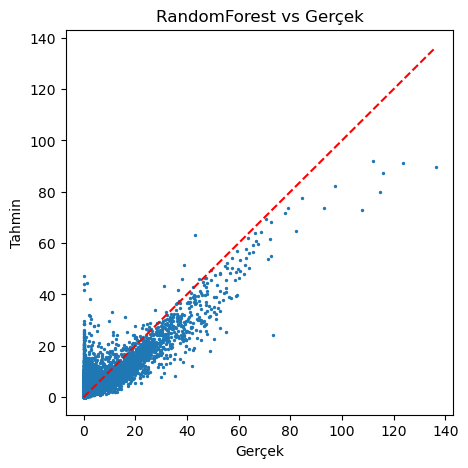

In [233]:
plt.figure(figsize=(5,5))
plt.scatter(y_te, y_hat, s=2)
m = max(y_te.max(), y_hat.max())
plt.plot([0,m],[0,m],"r--")
plt.xlabel("Gerçek"); plt.ylabel("Tahmin")
plt.title("RandomForest vs Gerçek"); plt.show()

In [ ]:
#Tahminlerimiz Mükemmel tahmin çizgisine oldukça yakın bu da iyi bir şey modelimizin başarıyla çalıştığını gösterir.

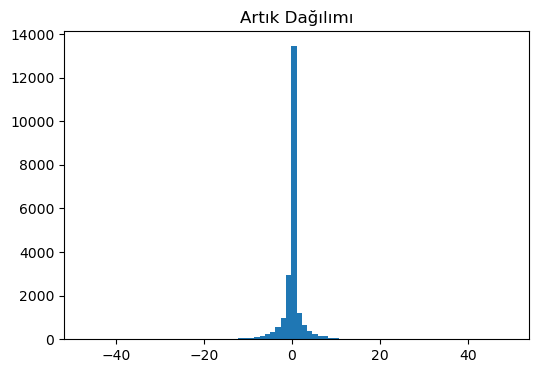

In [235]:
res = y_te - y_hat
plt.figure(figsize=(6,4))
plt.hist(res, bins=80); plt.title("Artık Dağılımı"); plt.show()

In [237]:
#Artık değerin açıklaması Gerçek Değerlerden Tahminlerin çıkarılması yani 0'a yaklaşması iyi bir şey yine.

In [239]:
#Yani sonuç olarak model kurulumumuz başarılı oldu.

In [247]:
#Şimdi son olarak modelimizi kaydedelim 

In [245]:
import joblib
joblib.dump(final_pipe, "rain_rf_model.joblib")


['rain_rf_model.joblib']